In [187]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum
from ase.optimize import LBFGS, BFGS
from ase import Atom

from ase.io.trajectory import Trajectory
from ase.md import Langevin, Bussi
from ase import io

plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 12,              
    "axes.labelsize": 14,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 12,        
    "ytick.labelsize": 12,       
    "legend.fontsize": 12,      
    "text.usetex": True       
})


#macemp = mace_mp(dispersion=True, default_dtype="float64")
macemp_omat = mace_mp(model="/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/mace-omat-0-medium.model", dispersion=True, default_dtype="float64")


Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/MACE-MP-0/Notebooks_mace/mace_test/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using TorchDFTD3Calculator for D3 dispersion corrections


In [10]:
import importlib
import interlayer_spacing
importlib.reload(interlayer_spacing)

from interlayer_spacing import calculate_interlayer_spacing, set_interlayer_spacing

In [141]:
# exclude pre-equilibration
mg_na_traj = io.read("trajectories/mg_na_omat_25000.traj", index="100:")
mgo_na_traj = io.read("trajectories/mgo_na_omat_25000.traj", index="100:")
mgoh_na_traj = io.read("trajectories/mgoh_na_omat_25000.traj", index="100:")

In [415]:
mg_na_traj_flip = io.read("trajectories/mg_na_omat_flipped_25000.traj", index=":")
mgo_na_traj_flip = io.read("trajectories/mgo_na_omat_flipped_25000.traj", index=":")
mgoh_na_traj_flip = io.read("trajectories/mgoh_na_omat_flipped_25000.traj", index=":")

In [486]:
mg_na_many_traj = io.read("trajectories/mg_na_many_omat_25000.traj", index=":")
mgo_na_many_traj = io.read("trajectories/mgo_na_many_omat_25000.traj", index=":")
mgoh_na_many_traj = io.read("trajectories/mgoh_na_many_omat_25000.traj", index=":")

### Heatmap of interlayer spacing
- LHS figure 6: image of last frame strucutre in the paper
- divide the xy plane of the lattice into 8x8 grids

In [16]:
na_indices = [atom.index for atom in mg_na_traj[0] if atom.symbol == 'Na']

calculate_interlayer_spacing(mg_na_traj[0])

4.083286694249999

In [44]:
mg_na_traj[0]

Atoms(symbols='C66NaO32Ti32', pbc=[True, True, False], cell=[[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]], momenta=..., tags=..., constraint=[<ase.constraints.FixSubsetCom object at 0x325598b30>, <ase.constraints.FixSubsetCom object at 0x334d56930>], calculator=SinglePointCalculator(...))

In [20]:
mg_na_traj[0].cell

Cell([[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]])

In [ ]:
def interlayer_spacing_section(atoms):
    mxene_atoms = [atom for atom in atoms if atom.tag in [0,1,2,3] and atom.symbol != 'Na']
    graphene_atoms = [atom for atom in atoms if atom.tag == 10]
    graphene_avg_z = np.mean([atom.position[2] for atom in graphene_atoms])

    top_O = [atom for atom in mxene_atoms if atom.tag == 3]
    mxene_z = np.mean([atom.position[2] for atom in top_O]) if top_O else max(atom.position[2] for atom in mxene_atoms)

    return graphene_avg_z - mxene_z

In [28]:
from ase.geometry import find_mic

grid_size = 8


cell = mg_na_traj[0].cell
# create a hexagonal grid
inv_cell = np.linalg.inv(cell[:2, :2].T)  # Inverse of the 2D cell basis (XY-plane)

# Define the 8×8 hexagonal grid in fractional coordinates
num_bins = 8
grid_frac_x = np.linspace(0, 1, num_bins + 1)  # Fractional coords along a1
grid_frac_y = np.linspace(0, 1, num_bins + 1)  # Fractional coords along a2
X_frac, Y_frac = np.meshgrid(grid_frac_x[:-1], grid_frac_y[:-1])  # Grid center positions

interlayer_spacing = np.zeros((num_bins, num_bins, len(mg_na_traj)))

In [52]:
cell

Cell([[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]])

In [58]:
cell[0]

array([12.12,  0.  ,  0.  ])

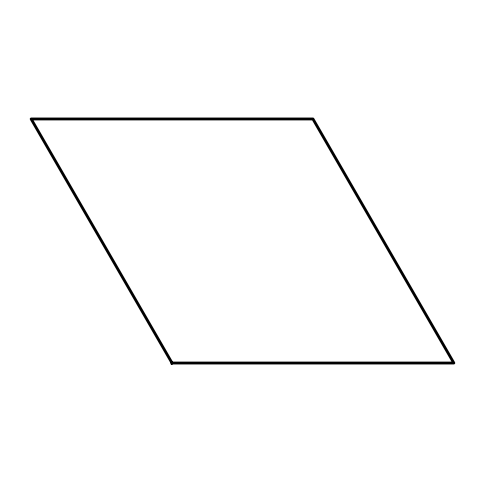

In [ ]:
a1, a2 = cell[0][:2], cell[1][:2]

parallelogram = np.array([
    np.array([0, 0]),
    a1,
    a1 + a2,     
    a2,          
    np.array([0, 0])
])

plt.figure(figsize=(6, 6))
plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=2)

#plt.scatter(parallelogram[:, 0], parallelogram[:, 1], color='red', zorder=3) # vertices

plt.axis("equal")
plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.axis("off")
plt.show()


In [111]:
def interlayer_spacing_section(atoms, section_center, section_size):
    """Compute interlayer spacing for atoms within a given section."""
    x_min, x_max = section_center[0] - section_size / 2, section_center[0] + section_size / 2
    y_min, y_max = section_center[1] - section_size / 2, section_center[1] + section_size / 2

    section_atoms = [atom for atom in atoms if x_min <= atom.position[0] <= x_max and y_min <= atom.position[1] <= y_max]

    mxene_atoms = [atom for atom in section_atoms if atom.tag in [0,1,2,3] and atom.symbol != 'Na']
    graphene_atoms = [atom for atom in section_atoms if atom.tag == 10]

    if not mxene_atoms or not graphene_atoms:
        print("No atoms in section")
        return np.nan  # Skip empty sections

    graphene_avg_z = np.mean([atom.position[2] for atom in graphene_atoms])

    
    top_O = [atom for atom in mxene_atoms if atom.tag == 3]
    if top_O:
        #print("top O in section")
        mxene_z = np.mean([atom.position[2] for atom in top_O])
        print("mxene z: ", mxene_z)
    else:
        mxene_z = np.max([atom.position[2] for atom in mxene_atoms])
        print("mxene z no O: ", mxene_z)
    #mxene_z = np.mean([atom.position[2] for atom in top_O]) if top_O else (max(atom.position[2] for atom in mxene_atoms) and print("no O"))

    return graphene_avg_z - mxene_z

mxene z no O:  10.16629184
mxene z no O:  10.17245711
mxene z:  12.39537059
mxene z:  12.39403068
mxene z no O:  10.16403386
No atoms in section
mxene z no O:  11.46027949
mxene z no O:  10.15134879
mxene z no O:  11.46361129
mxene z no O:  11.46444432
mxene z no O:  11.46032556
No atoms in section
mxene z no O:  11.46407859
mxene z:  12.38277499
mxene z:  12.39790813
mxene z no O:  11.37823783
mxene z no O:  11.46374017
No atoms in section
mxene z no O:  11.46983612
mxene z:  12.39458017
mxene z:  12.39612902
mxene z:  12.39839821
mxene z no O:  11.46495535
No atoms in section
mxene z no O:  11.46699661
mxene z:  12.39753591
mxene z:  12.39433004
mxene z:  12.38261876
mxene z no O:  10.15239226
No atoms in section
No atoms in section
No atoms in section
No atoms in section
No atoms in section
No atoms in section
No atoms in section
mxene z no O:  10.236894938358649
mxene z no O:  10.145696066722913
mxene z:  12.448956215878669
mxene z:  12.409169567802298
mxene z no O:  10.11882749781

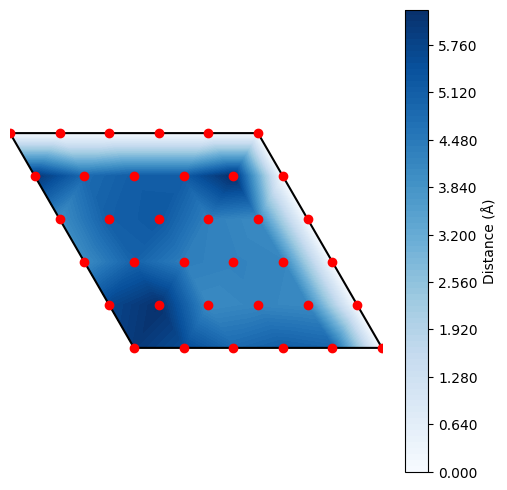

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from ase import io

# Load trajectory
mg_na_traj = io.read("trajectories/mg_na_omat_25000.traj", ":")

# Extract cell parameters (parallelogram)
cell = mg_na_traj[0].cell
a1, a2 = cell[0][:2], cell[1][:2]  # Only x and y components for 2D representation

# Define grid resolution
num_x, num_y = 6, 6  # Adjust for resolution
x_vals = np.linspace(0, 1, num_x)
y_vals = np.linspace(0, 1, num_y)

# Generate grid points as section centers
grid_centers = np.array([x * a1 + y * a2 for x in x_vals for y in y_vals])



# Initialize array to store interlayer spacing for each grid section
interlayer_spacing_values = np.zeros(len(grid_centers))

# Define section size based on grid resolution
section_size = np.linalg.norm(a1) / num_x  

# Iterate over trajectory frames and compute interlayer spacing for each section
for frame in mg_na_traj[:10]:  # Use first 10 frames for efficiency
    spacing_grid = np.array([interlayer_spacing_section(frame, center, section_size) for center in grid_centers])
    interlayer_spacing_values += np.nan_to_num(spacing_grid)  # Ignore NaN values

interlayer_spacing_values /= len(mg_na_traj[:10])  # Average over frames

# Define parallelogram shape
parallelogram = np.array([
    np.array([0, 0]),   # Origin
    a1,                 # First vector
    a1 + a2,            # First + Second vector
    a2,                 # Second vector
    np.array([0, 0])    # Close the loop
])

# Plot heatmap inside parallelogram
plt.figure(figsize=(6, 6))

#from scipy.ndimage import gaussian_filter
#smooth_interlayer_spacing = gaussian_filter(interlayer_spacing_values, sigma=0.5)

plt.tricontourf(grid_centers[:, 0], grid_centers[:, 1], interlayer_spacing_values, levels=100, cmap="Blues")

# Overlay parallelogram boundary
plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1.5)

# Formatting
plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.axis("off")  # Remove axes

# Colorbar with fixed formatting (3 decimal places)
cbar = plt.colorbar(label="Distance (Å)")
cbar.formatter = ticker.FormatStrFormatter("%.3f")  
cbar.update_ticks()

# plot grid centres
plt.scatter(grid_centers[:, 0], grid_centers[:, 1], color='red', zorder=3) # vertices


# Show plot
plt.show()


In [147]:
def interlayer_spacing_section(atoms, section_center, section_size):
    """Compute interlayer spacing for atoms within a given section defined by corners."""
    x_min, x_max = section_center[0] - section_size / 2, section_center[0] + section_size / 2
    y_min, y_max = section_center[1] - section_size / 2, section_center[1] + section_size / 2

    

    # Select atoms in this section
    section_atoms = [atom for atom in atoms if x_min <= atom.position[0] <= x_max and y_min <= atom.position[1] <= y_max]

    if not section_atoms:
        graphene_avg_z = np.mean([atom.position[2] for atom in atoms if atom.tag == 10])  # Global graphene avg
        mxene_z = max(atom.position[2] for atom in atoms if atom.tag == 3 and atom.symbol != 'Na')  # Global MXene max
        return graphene_avg_z - mxene_z

    # Separate atoms into graphene and MXene
    graphene_atoms = [atom for atom in section_atoms if atom.tag == 10]
    mxene_atoms = [atom for atom in section_atoms if atom.tag == 3 and atom.symbol != 'Na']
    top_O = [atom for atom in mxene_atoms if atom.tag == 3]  # O atoms

    # Compute graphene height
    if graphene_atoms:
        graphene_avg_z = np.mean([atom.position[2] for atom in graphene_atoms])
    else:
        graphene_avg_z = np.mean([atom.position[2] for atom in atoms if atom.tag == 10]) # Global graphene avg

    # Compute MXene height
    if top_O:
        mxene_z = np.mean([atom.position[2] for atom in top_O])
    else:
        #mxene_z = max(atom.position[2] for atom in mxene_atoms) if mxene_atoms else np.mean([atom.position[2] for atom in atoms if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])
        mxene_z = np.mean([atom.position[2] for atom in atoms if atom.tag == 3 and atom.symbol != 'Na'])
    return graphene_avg_z - mxene_z


In [146]:
np.mean([atom.position[2] for atom in mg_na_traj[500] if atom.tag == 3 and atom.symbol != 'Na'])

12.390918768212867

In [145]:
np.mean([atom.position[2] for atom in mgo_na_traj[500] if atom.tag == 10])  # Global graphene avg

16.534222264559904

In [160]:
na_pos = [atom.position[:2] for atom in mg_na_traj[0] if atom.symbol == 'Na'][0]
na_pos

array([3.04901013, 5.21016283])

- choose no. frames to avg over

Python(67386) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67387) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67396) Malloc

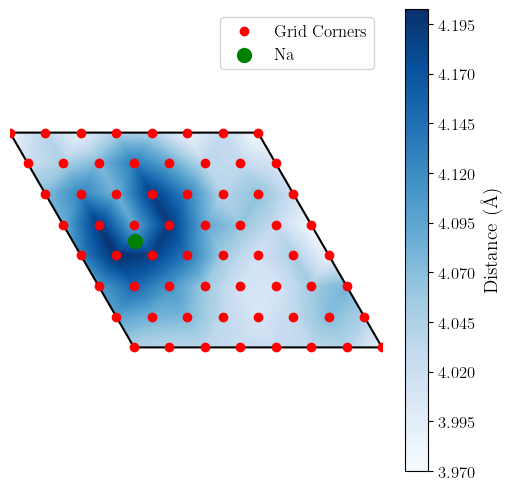

In [511]:
import matplotlib.ticker as ticker


mg_na_traj = io.read("trajectories/mg_na_omat_flipped_25000.traj", index=":")

# Extract cell parameters (parallelogram)
cell = mg_na_traj[0].cell
a1, a2 = cell[0][:2], cell[1][:2]  # Only x and y components for 2D representation

# Define grid resolution (Grid **corners**, not centers)
num_x, num_y = 8,8

# Generate grid points as corners
x_vals = np.linspace(0, 1, num_x)
y_vals = np.linspace(0, 1, num_y)
grid_corners = np.array([x * a1 + y * a2 for x in x_vals for y in y_vals])

# Initialize array to store interlayer spacing for each grid section
interlayer_spacing_values = np.zeros(len(grid_corners))

# Define section size based on grid resolution
section_size = np.linalg.norm(a1) / (num_x - 1)  # Adjusted for corner grid

frames = mg_na_traj[:2000]

# Compute interlayer spacing per grid **corner** and average over frames
for frame in frames:  # Use first 10 frames
    spacing_grid = np.array([interlayer_spacing_section(frame, corner, section_size) for corner in grid_corners])
    interlayer_spacing_values += np.nan_to_num(spacing_grid)  # Replace NaN with zero for summation

interlayer_spacing_values /= len(frames)  # Average over frames

# Define parallelogram shape
parallelogram = np.array([
    np.array([0, 0]),   # Origin
    a1,                 # First vector
    a1 + a2,            # First + Second vector
    a2,                 # Second vector
    np.array([0, 0])    # Close the loop
])

# Plot heatmap inside parallelogram
plt.figure(figsize=(6, 6))

from scipy.ndimage import gaussian_filter
smooth_interlayer_spacing = gaussian_filter(interlayer_spacing_values, sigma=0.5)

plt.tricontourf(grid_corners[:, 0], grid_corners[:, 1], smooth_interlayer_spacing, levels=100, cmap="Blues")

# Overlay parallelogram boundary
plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1.5)

# Formatting
plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.axis("off")  # Remove axes

# Colorbar with fixed formatting (3 decimal places)
cbar = plt.colorbar(label="Distance (Å)")
cbar.formatter = ticker.FormatStrFormatter("%.3f")  
cbar.update_ticks()

# Plot grid **corners** (was grid centers before)
plt.scatter(grid_corners[:, 0], grid_corners[:, 1], color='red', zorder=3, label="Grid Corners")

na_pos = [atom.position[:2] for atom in mg_na_traj[-1] if atom.symbol == 'Na'][0]
plt.scatter(na_pos[0], na_pos[1], color='green', zorder=3, label="Na", s=100)

# plot O atom with tag 11 if present
graphene_O = [atom.position[:2] for atom in mg_na_traj[-1] if atom.tag == 11]
if graphene_O:
    plt.scatter(graphene_O[0][0], graphene_O[0][1], color='orange', zorder=3, label="O", s=100)
graphene_H = [atom.position[:2] for atom in mg_na_traj[-1] if atom.tag == 12]
if graphene_H:
    plt.scatter(graphene_H[0][0], graphene_H[0][1], color='purple', zorder=3, label="H", s=100)

plt.legend()

# Show plot
plt.show()


### Heatmap of multiple Na ions

Python(67409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67420) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67421) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67422) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(67423) Malloc

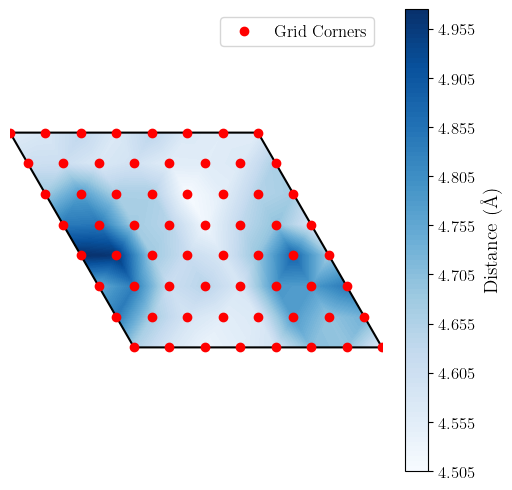

In [512]:
import matplotlib.ticker as ticker

mg_na_many_traj_500 = io.read("trajectories/mg_na_many_omat_25000.traj", index="500:")
mgo_na_many_traj_500 = io.read("trajectories/mgo_na_many_omat_25000.traj", index="500:")
mgoh_na_many_traj_500 = io.read("trajectories/mgoh_na_many_omat_25000.traj", index="500:")

traj = mgoh_na_many_traj_500

# Extract cell parameters (parallelogram)
cell = traj[0].cell
a1, a2 = cell[0][:2], cell[1][:2]  # Only x and y components for 2D representation

# Define grid resolution (Grid **corners**, not centers)
num_x, num_y = 8,8

# Generate grid points as corners
x_vals = np.linspace(0, 1, num_x)
y_vals = np.linspace(0, 1, num_y)
grid_corners = np.array([x * a1 + y * a2 for x in x_vals for y in y_vals])

# Initialize array to store interlayer spacing for each grid section
interlayer_spacing_values = np.zeros(len(grid_corners))

# Define section size based on grid resolution
section_size = np.linalg.norm(a1) / (num_x - 1)  # Adjusted for corner grid

frames = traj[:1000]

# Compute interlayer spacing per grid **corner** and average over frames
for frame in frames:  # Use first 10 frames
    spacing_grid = np.array([interlayer_spacing_section(frame, corner, section_size) for corner in grid_corners])
    interlayer_spacing_values += np.nan_to_num(spacing_grid)  # Replace NaN with zero for summation

interlayer_spacing_values /= len(frames)  # Average over frames

# Define parallelogram shape
parallelogram = np.array([
    np.array([0, 0]),   # Origin
    a1,                 # First vector
    a1 + a2,            # First + Second vector
    a2,                 # Second vector
    np.array([0, 0])    # Close the loop
])

# Plot heatmap inside parallelogram
plt.figure(figsize=(6, 6))

from scipy.ndimage import gaussian_filter
smooth_interlayer_spacing = gaussian_filter(interlayer_spacing_values, sigma=0.5)

plt.tricontourf(grid_corners[:, 0], grid_corners[:, 1], smooth_interlayer_spacing, levels=100, cmap="Blues")

# Overlay parallelogram boundary
plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1.5)

# Formatting
plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.axis("off")  # Remove axes

# Colorbar with fixed formatting (3 decimal places)
cbar = plt.colorbar(label="Distance (Å)")
cbar.formatter = ticker.FormatStrFormatter("%.3f")  
cbar.update_ticks()

# Plot grid **corners** (was grid centers before)
plt.scatter(grid_corners[:, 0], grid_corners[:, 1], color='red', zorder=3, label="Grid Corners")

#na_pos = [atom.position[:2] for atom in mg_na_traj[-1] if atom.symbol == 'Na'][0]
#plt.scatter(na_pos[0], na_pos[1], color='green', zorder=3, label="Na", s=100)

# plot O atom with tag 11 if present
graphene_O = [atom.position[:2] for atom in mg_na_traj[-1] if atom.tag == 11]
if graphene_O:
    plt.scatter(graphene_O[0][0], graphene_O[0][1], color='orange', zorder=3, label="O", s=100)
graphene_H = [atom.position[:2] for atom in mg_na_traj[-1] if atom.tag == 12]
if graphene_H:
    plt.scatter(graphene_H[0][0], graphene_H[0][1], color='purple', zorder=3, label="H", s=100)

plt.legend()

# Show plot
plt.show()

### MSD of a single Na ion

- non-linear MSD: hindrance to sodium ion diffusion -> bad

$$MSD(\tau) = \langle |r(t+\tau) - r(t)|^2 \rangle$$
- need an ensembl avg
- treat each time step as a new starting point
- use a sliding window avg


In [176]:
mg_na_traj[0][-1]

Atom('Na', [3.049010126707053, 5.210162831657062, 13.880788314391625], tag=0, momentum=[-0.5375451442731526, -0.7919408667589315, -0.5159708706629739], index=-1)

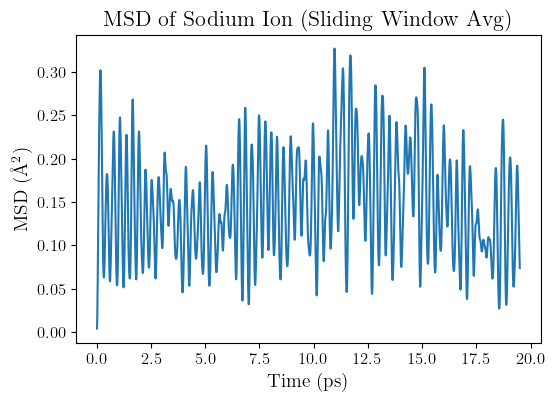

In [507]:
import numpy as np
from ase.io import Trajectory
import matplotlib.pyplot as plt

# mg_na_traj_500 = io.read("trajectories/mg_na_omat_25000.traj", index="500:")
# mgo_na_traj_500 = io.read("trajectories/mgo_na_omat_25000.traj", index=":")
# mgoh_na_traj_500 = io.read("trajectories/mgoh_na_omat_25000.traj", index=":")

mg_na_traj_500 = io.read("trajectories/mg_na_omat_flipped_25000.traj", index="500:")
mgo_na_traj_500 = io.read("trajectories/mgo_na_omat_flipped_25000.traj", index="500:")
mgoh_na_traj_500 = io.read("trajectories/mgoh_na_omat_flipped_25000.traj", index="500:")


traj = mgoh_na_traj_500

# Identify the sodium ion
sodium_indices = [i for i, atom in enumerate(traj[0]) if atom.symbol == 'Na']

sodium_index = sodium_indices[0]

positions = np.array([atoms[sodium_index].position for atoms in traj])

n_frames = len(positions)
window_size = 50
max_tau = n_frames - window_size

msd = np.zeros(max_tau)

for tau in range(1, max_tau):
    displacements = positions[tau:tau+window_size] - positions[:window_size]
    squared_displacements = np.sum(displacements**2, axis=1)
    msd[tau] = np.mean(squared_displacements)  # moving average over window

time_step = 1
time_axis = np.arange(1, max_tau) * time_step / 100  # Convert to ps

# Plot MSD
plt.figure(figsize=(6, 4))
plt.plot(time_axis, msd[1:])
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD ($\mathrm{\AA^2}$)")
plt.title("MSD of Sodium Ion (Sliding Window Avg)")
plt.show()


### MSD of the most mobile sodium ion from 1/2 ML coverage

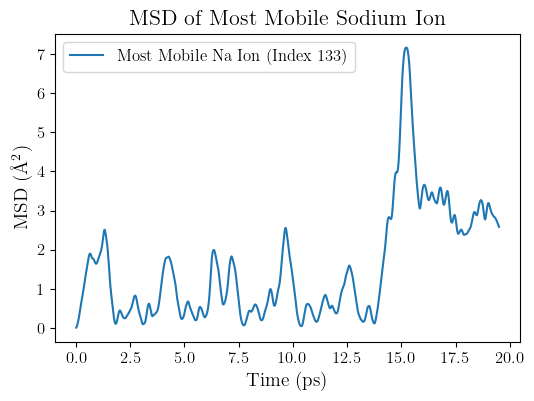

In [487]:
mg_na_many_traj_500 = io.read("trajectories/mg_na_many_omat_25000.traj", index="500:")
mgo_na_many_traj_500 = io.read("trajectories/mgo_na_many_omat_25000.traj", index="500:")
mgoh_na_many_traj_500 = io.read("trajectories/mgoh_na_many_omat_25000.traj", index=":")

traj = mg_na_many_traj_500

sodium_indices = [i for i, atom in enumerate(traj[0]) if atom.symbol == 'Na']
num_na = len(sodium_indices)

# initial positions of all Na ions
initial_positions = np.array([traj[0][i].position for i in sodium_indices])

# total displacement of each Na ion, find max
final_positions = np.array([traj[-1][i].position for i in sodium_indices])
total_displacements = np.linalg.norm(final_positions - initial_positions, axis=1)

most_mobile_index = sodium_indices[np.argmax(total_displacements)]

positions = np.array([atoms[most_mobile_index].position for atoms in traj])

# Compute MSD using a sliding window
n_frames = len(positions)
window_size = 50  # Define window size
max_tau = n_frames - window_size

msd = np.zeros(max_tau)

for tau in range(1, max_tau):
    displacements = positions[tau:tau+window_size] - positions[:window_size]  # Compute displacement
    squared_displacements = np.sum(displacements**2, axis=1)  # Squared displacement
    msd[tau] = np.mean(squared_displacements)  # Moving average over window

time_step = 1  # Adjust based on your trajectory timestep
time_axis = np.arange(1, max_tau) * time_step / 100  # Convert to ps

# Plot MSD
plt.figure(figsize=(6, 4))
plt.plot(time_axis, msd[1:], label=f"Most Mobile Na Ion (Index {most_mobile_index})")
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD ($\mathrm{\AA^2}$)")
plt.title("MSD of Most Mobile Sodium Ion")
plt.legend()
plt.show()

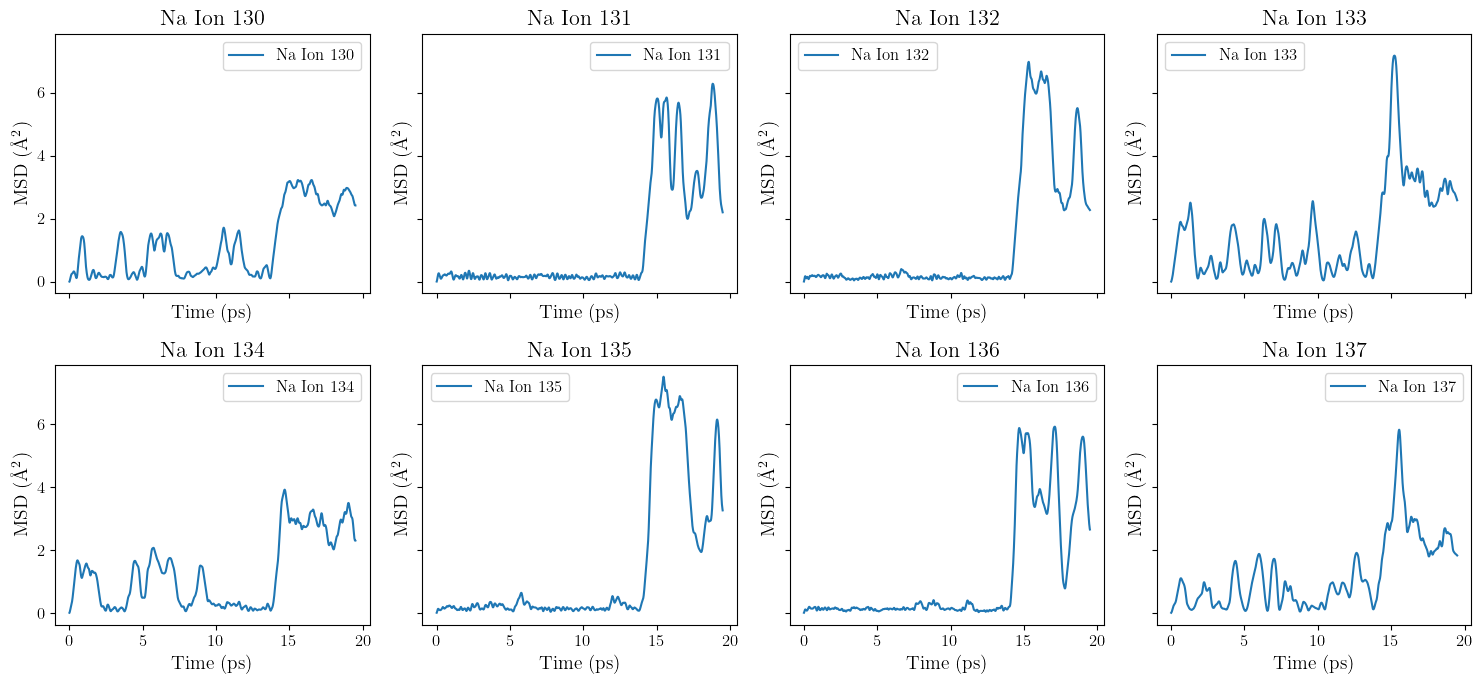

In [493]:


traj = mg_na_many_traj_500  # Select the trajectory

# Get sodium indices
sodium_indices = [i for i, atom in enumerate(traj[0]) if atom.symbol == 'Na']
num_na = len(sodium_indices)

# Prepare MSD calculations
n_frames = len(traj)
window_size = 50  # Define window size
max_tau = n_frames - window_size

# Set up subplots: 2 rows × 4 columns
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten for easy iteration

time_step = 1  # Adjust based on your trajectory timestep
time_axis = np.arange(1, max_tau) * time_step / 100  # Convert to ps

# Loop over all Na ions
for i, na_index in enumerate(sodium_indices):
    positions = np.array([atoms[na_index].position for atoms in traj])  # Get positions for this Na ion
    msd = np.zeros(max_tau)

    # Compute MSD using sliding window
    for tau in range(1, max_tau):
        displacements = positions[tau:tau+window_size] - positions[:window_size]
        squared_displacements = np.sum(displacements**2, axis=1)
        msd[tau] = np.mean(squared_displacements)

    # Plot in the corresponding subplot
    ax = axes[i]
    ax.plot(time_axis, msd[1:], label=f"Na Ion {na_index}")
    ax.set_title(f"Na Ion {na_index}")
    ax.set_xlabel("Time (ps)")
    ax.set_ylabel(r"MSD ($\mathrm{\AA^2}$)")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


Collective MSG

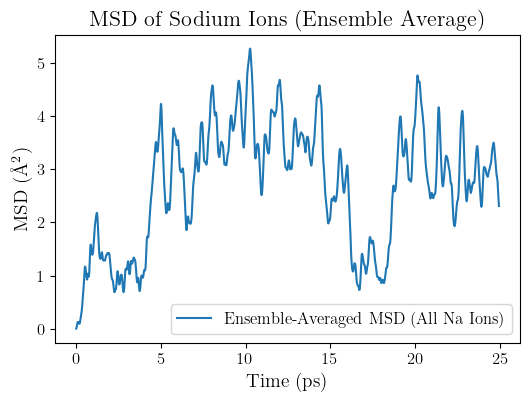

In [497]:

traj = mgoh_na_many_traj_500  # Select trajectory

# Get sodium indices
sodium_indices = [i for i, atom in enumerate(traj[0]) if atom.symbol == 'Na']
num_na = len(sodium_indices)

# Initialize MSD calculation
n_frames = len(traj)
window_size = 5  # Define window size
max_tau = n_frames - window_size

# Store MSD values
msd_all_na = np.zeros(max_tau)

# Compute MSD for all Na ions
for na_index in sodium_indices:
    positions = np.array([atoms[na_index].position for atoms in traj])  # Get positions for this Na ion
    
    msd = np.zeros(max_tau)
    for tau in range(1, max_tau):
        displacements = positions[tau:tau+window_size] - positions[:window_size]
        squared_displacements = np.sum(displacements**2, axis=1)
        msd[tau] = np.mean(squared_displacements)  # Average over time window

    msd_all_na += msd  # Sum MSD contributions from each Na ion

# Normalize by number of Na ions to get the ensemble MSD
msd_all_na /= num_na

# Time axis (adjust units)
time_step = 1  # Adjust based on trajectory timestep
time_axis = np.arange(1, max_tau) * time_step / 100  # Convert to ps

# Plot the ensemble MSD
plt.figure(figsize=(6, 4))
plt.plot(time_axis, msd_all_na[1:], label="Ensemble-Averaged MSD (All Na Ions)")
plt.xlabel("Time (ps)")
plt.ylabel(r"MSD ($\mathrm{\AA^2}$)")
plt.title("MSD of Sodium Ions (Ensemble Average)")
plt.legend()
plt.show()


### Na probability distribution

In [358]:
mg_na_traj = io.read("trajectories/mg_na_omat_25000.traj", index=":")
na_indices_mg = [atom.index for atom in mg_na_traj[0] if atom.symbol == 'Na']
na_positions_mg = np.array([[atoms.positions[i] for i in na_indices_mg] for atoms in mg_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mg = na_positions_mg[:, 0, :2]

In [359]:
mgo_na_traj = io.read("trajectories/mgo_na_omat_25000.traj", index=":")
na_indices_mgo = [atom.index for atom in mgo_na_traj[0] if atom.symbol == 'Na']
na_positions_mgo = np.array([[atoms.positions[i] for i in na_indices_mgo] for atoms in mgo_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mgo = na_positions_mgo[:, 0, :2]

In [360]:
mgoh_na_traj = io.read("trajectories/mgoh_na_omat_25000.traj", index=":")
na_indices_mgoh = [atom.index for atom in mgoh_na_traj[0] if atom.symbol == 'Na']
na_positions_mgoh = np.array([[atoms.positions[i] for i in na_indices_mgoh] for atoms in mgoh_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mgoh = na_positions_mgoh[:, 0, :2]

In [244]:
mxene_atoms = Atoms([atom for atom in mg_na_traj[0] if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])

Point (13, 5) is above the line: True


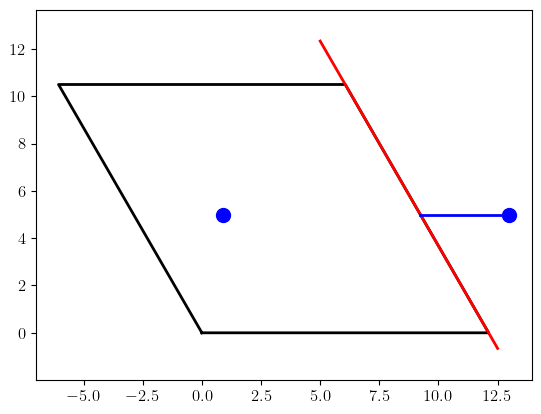

In [ ]:
cell = mg_na_traj[0].cell
a1, a2 = cell[0][:2], cell[1][:2]
parallelogram = np.array([
    np.array([0, 0]),
    a1,
    a1 + a2,
    a2,
    np.array([0, 0])
])

plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=2)
x_vals = np.linspace(5, 12.5, 10)  # x-coordinates
y_vals = - np.sqrt(3) * x_vals + np.sqrt(3) * a1[0]  

plt.plot(x_vals, y_vals, 'r-', linewidth=2)
plt.axis("equal")


def is_above_line(x, y, a1):

    if y > - np.sqrt(3) * x + np.sqrt(3) * a1[0]:
        # find intercept with line if you draw a line paralell to the x-axis from the point
        # y = -sqrt(3) * x + sqrt(3) * a1[0]
        x_on_line = (y - np.sqrt(3) * a1[0]) / (-np.sqrt(3))
        x_dist = x - x_on_line

        plt.plot([x, x_on_line], [y, y], 'b-', linewidth=2)
        
        # find intercept with other parallel line: y = -sqrt(3) * x
        x_on_other_line = y / (-np.sqrt(3))
        # translate point back into the cell
        new_x = x_on_other_line + x_dist
        plt.plot(new_x, y, 'bo', markersize=10)
    else:
        return False

    return y > - np.sqrt(3) * x + np.sqrt(3) * a1[0]

x_test, y_test = 13, 5  # Change these values to test

plt.plot(x_test, y_test, 'bo', markersize=10)

result = is_above_line(x_test, y_test, a1)
print(f"Point ({x_test}, {y_test}) is above the line:", result)

In [ ]:
def is_above_line(x, y, a1):

    if y > - np.sqrt(3) * x + np.sqrt(3) * a1[0]:
        # find intercept with line if you draw a line paralell to the x-axis from the point
        # y = -sqrt(3) * x + sqrt(3) * a1[0]
        x_on_line = (y - np.sqrt(3) * a1[0]) / (-np.sqrt(3))
        x_dist = x - x_on_line
        
        # find intercept with other parallel line: y = -sqrt(3) * x
        x_on_other_line = y / (-np.sqrt(3))
        # translate point back into the cell
        new_x = x_on_other_line + x_dist
    else:
        return x

    return new_x

In [331]:
if is_above_line(55, 10, a1):
    print("yes")

yes


In [361]:
def fold_into_unit_cell(x, y, a1, a2):
    A = np.column_stack((a1, a2))
    fractional_coords = np.linalg.solve(A, np.array([x, y]))
    fractional_coords -= np.floor(fractional_coords)
    new_coords = A @ fractional_coords
    return new_coords[0], new_coords[1]

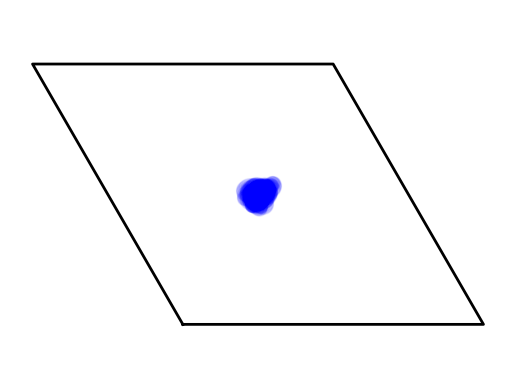

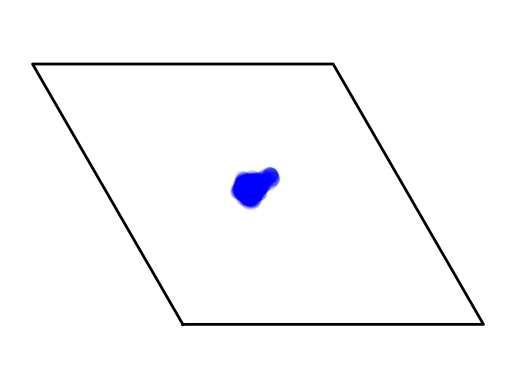

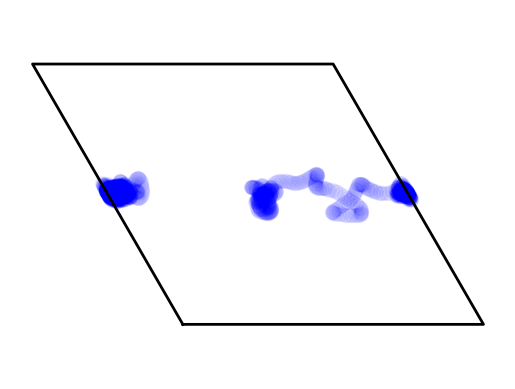

In [383]:
cell = mg_na_traj[0].cell
a1, a2 = cell[0][:2], cell[1][:2]

parallelogram = np.array([
    np.array([0, 0]),
    a1,
    a1 + a2,
    a2,
    np.array([0, 0])
])

na_positions_mg_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mg])
na_positions_mgo_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgo])
na_positions_mgoh_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgoh])

for i in [na_positions_mg_folded, na_positions_mgo_folded, na_positions_mgoh_folded]:
    plt.scatter(i[:, 0], i[:, 1], s=100, alpha=0.05, color="blue")
    plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=2)
    plt.axis("equal")
    plt.xlabel("x (Å)")
    plt.ylabel("y (Å)")
    plt.axis("off")
    plt.show()



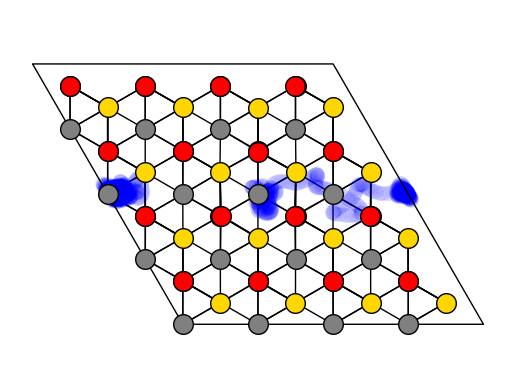

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
from ase.visualize.plot import plot_atoms
from scipy.spatial.distance import pdist, squareform

na_positions_mg_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mg])
na_positions_mgo_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgo])
na_positions_mgoh_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgoh])


# Load MXene structure as ASE Atoms object
mxene_atoms = Atoms([atom for atom in mg_na_traj[0] if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])

# Extract atomic positions for bonding
positions = mxene_atoms.get_positions()[:, :2]  # Use only x, y coordinates
num_atoms = len(positions)

# Define bond cutoff (adjust if necessary)
bond_cutoff = 2.5  # Å, typical for metal-metal bonding

# Compute pairwise distances
dist_matrix = squareform(pdist(positions))

tags = mxene_atoms.get_tags()
color_map = {0: "gold", 1: "red", 2: "grey", 3: "red"}  # Ti = gold, O = red, C = grey
atom_colors = [color_map[tag] for tag in tags]


plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1)

for i, pos in enumerate(positions):
    if tags[i] != 1:
        plt.scatter(pos[0], pos[1], s=200, c=atom_colors[i], edgecolors="black", label="MXene atoms", zorder=2)
        #plt.scatter(position[:, 0], position[:, 1], s=200, c=atom_colors, edgecolors="black", label="MXene atoms", zorder=2)


# Plot bonds manually by connecting atoms within the cutoff
for i in range(num_atoms):
    for j in range(i + 1, num_atoms):  # Avoid duplicate pairs
        if dist_matrix[i, j] < bond_cutoff:
            if tags[i] != 1:
                plt.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], 'k-', linewidth=1, zorder=1)


plt.scatter(na_positions_mgoh_folded[:, 0], na_positions_mgoh_folded[:, 1], s=100, alpha=0.05, color="blue")



plt.axis("equal")
plt.axis("off")
plt.show()


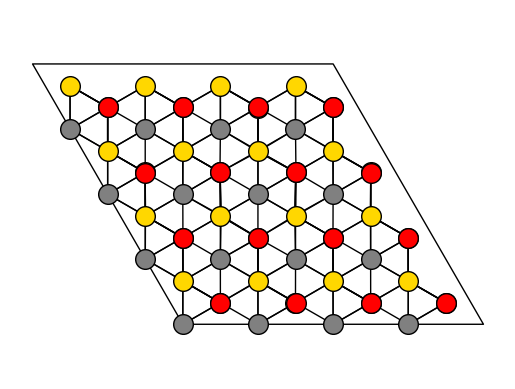

In [413]:
plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1)

for i, pos in enumerate(positions):
    if tags[i] != 3:
        plt.scatter(pos[0], pos[1], s=200, c=atom_colors[i], edgecolors="black", label="MXene atoms", zorder=2)
        #plt.scatter(position[:, 0], position[:, 1], s=200, c=atom_colors, edgecolors="black", label="MXene atoms", zorder=2)


# Plot bonds manually by connecting atoms within the cutoff
for i in range(num_atoms):
    for j in range(i + 1, num_atoms):  # Avoid duplicate pairs
        if dist_matrix[i, j] < bond_cutoff:
            if tags[i] != 1:
                plt.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], 'k-', linewidth=1, zorder=1)


    

plt.axis("equal")
plt.axis("off")
plt.show()

Flipped

In [ ]:
mg_na_traj = io.read("trajectories/mg_na_omat_flipped_25000.traj", index=":")
na_indices_mg = [atom.index for atom in mg_na_traj[0] if atom.symbol == 'Na']
na_positions_mg = np.array([[atoms.positions[i] for i in na_indices_mg] for atoms in mg_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mg = na_positions_mg[:, 0, :2]

In [417]:
mgo_na_traj = io.read("trajectories/mgo_na_omat_flipped_25000.traj", index=":")
na_indices_mgo = [atom.index for atom in mgo_na_traj[0] if atom.symbol == 'Na']
na_positions_mgo = np.array([[atoms.positions[i] for i in na_indices_mgo] for atoms in mgo_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mgo = na_positions_mgo[:, 0, :2]

In [418]:
mgoh_na_traj = io.read("trajectories/mgoh_na_omat_flipped_25000.traj", index=":")
na_indices_mgoh = [atom.index for atom in mgoh_na_traj[0] if atom.symbol == 'Na']
na_positions_mgoh = np.array([[atoms.positions[i] for i in na_indices_mgoh] for atoms in mgoh_na_traj]) # shape (n_frames, n_Na, 3)

# only using one Na to start
na_positions_mgoh = na_positions_mgoh[:, 0, :2]

In [419]:
mxene_atoms = Atoms([atom for atom in mg_na_traj[0] if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])

In [431]:
def plot_mxene(frame):
    
    cell = frame.cell
    a1, a2 = cell[0][:2], cell[1][:2]

    parallelogram = np.array([
        np.array([0, 0]),
        a1,
        a1 + a2,
        a2,
        np.array([0, 0])
    ])
    
    plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1)


    mxene_atoms = Atoms([atom for atom in frame if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])
    positions = mxene_atoms.get_positions()[:, :2]
    num_atoms = len(positions)
    
    bond_cutoff = 2.5
    
    dist_matrix = squareform(pdist(positions))

    tags = mxene_atoms.get_tags()
    color_map = {0: "gold", 1: "red", 2: "grey", 3: "red"}  # Ti = gold, O = red, C = grey
    atom_colors = [color_map[tag] for tag in tags]
    
    
    for i, pos in enumerate(positions):
        if tags[i] != 1:
            plt.scatter(pos[0], pos[1], s=200, c=atom_colors[i], edgecolors="black", label="MXene atoms", zorder=2)
            #plt.scatter(position[:, 0], position[:, 1], s=200, c=atom_colors, edgecolors="black", label="MXene atoms", zorder=2)


    # Plot bonds manually by connecting atoms within the cutoff
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):  # Avoid duplicate pairs
            if dist_matrix[i, j] < bond_cutoff:
                if tags[i] != 1:
                    plt.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], 'k-', linewidth=1, zorder=1)
    
    plt.axis("equal")
    plt.axis("off")

    return
        

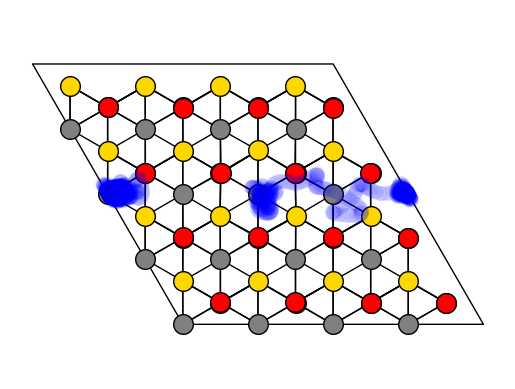

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
from ase.visualize.plot import plot_atoms
from scipy.spatial.distance import pdist, squareform

na_positions_mg_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mg])
na_positions_mgo_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgo])
na_positions_mgoh_folded = np.array([fold_into_unit_cell(x, y, a1, a2) for x, y in na_positions_mgoh])


# Load MXene structure as ASE Atoms object
mxene_atoms = Atoms([atom for atom in mg_na_traj[0] if atom.tag in [0,1,2,3] and atom.symbol != 'Na'])

# Extract atomic positions for bonding
positions = mxene_atoms.get_positions()[:, :2]  # Use only x, y coordinates
num_atoms = len(positions)

# Define bond cutoff (adjust if necessary)
bond_cutoff = 2.5  # Å, typical for metal-metal bonding

# Compute pairwise distances
dist_matrix = squareform(pdist(positions))

tags = mxene_atoms.get_tags()
color_map = {0: "gold", 1: "red", 2: "grey", 3: "red"}  # Ti = gold, O = red, C = grey
atom_colors = [color_map[tag] for tag in tags]


plt.plot(parallelogram[:, 0], parallelogram[:, 1], 'k-', linewidth=1)

for i, pos in enumerate(positions):
    if tags[i] != 1:
        plt.scatter(pos[0], pos[1], s=200, c=atom_colors[i], edgecolors="black", label="MXene atoms", zorder=2)
        #plt.scatter(position[:, 0], position[:, 1], s=200, c=atom_colors, edgecolors="black", label="MXene atoms", zorder=2)


# Plot bonds manually by connecting atoms within the cutoff
for i in range(num_atoms):
    for j in range(i + 1, num_atoms):  # Avoid duplicate pairs
        if dist_matrix[i, j] < bond_cutoff:
            if tags[i] != 1:
                plt.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], 'k-', linewidth=1, zorder=1)


#plt.scatter(na_positions_mg_folded[:, 0], na_positions_mg_folded[:, 1], s=100, alpha=0.05, color="green", zorder=10)
#plt.scatter(na_positions_mgo_folded[:, 0], na_positions_mgo_folded[:, 1], s=100, alpha=0.05, color="orange", zorder=10)
plt.scatter(na_positions_mgoh_folded[:, 0], na_positions_mgoh_folded[:, 1], s=100, alpha=0.05, color="blue", zorder=10)



plt.axis("equal")
plt.axis("off")
plt.show()

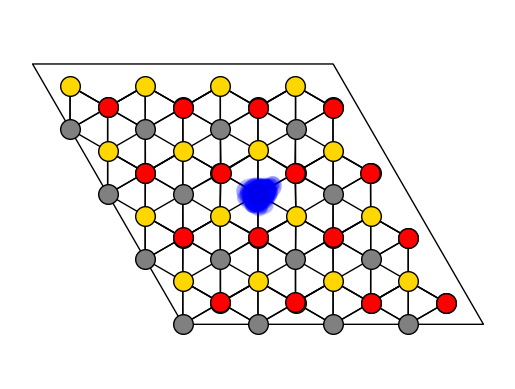

In [436]:
plot_mxene(mg_na_traj[0])
plt.scatter(na_positions_mg_folded[:, 0], na_positions_mg_folded[:, 1], s=100, alpha=0.05, color="blue", zorder=10)


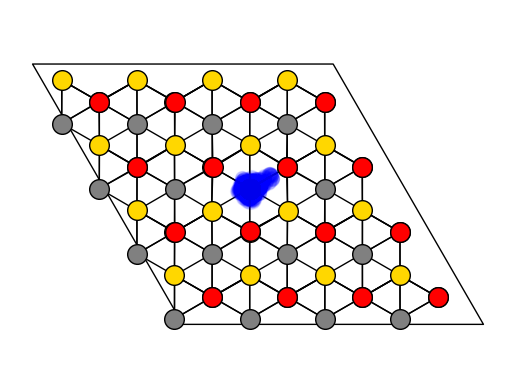

In [434]:
plot_mxene(mgo_na_traj[0])
plt.scatter(na_positions_mgo_folded[:, 0], na_positions_mgo_folded[:, 1], s=100, alpha=0.05, color="blue", zorder=10)

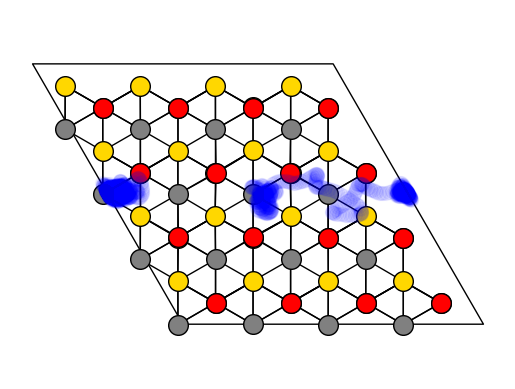

In [437]:
plot_mxene(mgoh_na_traj[0])
plt.scatter(na_positions_mgoh_folded[:, 0], na_positions_mgoh_folded[:, 1], s=100, alpha=0.05, color="blue", zorder=10)

### Open circuit voltage

$$OCV \approx - \frac{E_{Na_{x_2}/heterostructure} - E_{Na_{x_1}/heterostructure} - (x_2 - x_1)E_{Na}}{(x_2 - x_1)e} $$
- $E_{Na_{x_2}/heterostructure}$: energy of Na in heterostructure with x_2 Na ions

In [520]:
m_go_relaxed = io.read("structures/m_go_relaxed_omat.xyz")
m_go_na_relaxed = io.read("structures/m_go_na_relaxed_omat.xyz")
m_go_na_many_relaxed = io.read("structures/m_go_na_many_relaxed_omat.xyz")

In [521]:
m_go_relaxed

Atoms(symbols='C66O33Ti32', pbc=[True, True, False], cell=[[12.12, 0.0, 0.0], [-6.06, 10.496227893867395, 0.0], [0.0, 0.0, 40.0]], tags=..., calculator=SinglePointCalculator(...))

In [633]:
bulk_Na = bulk("Na", "bcc", a=4.23)
Na_supercell = bulk_Na.repeat((10, 10, 10))
Na_supercell.calc = macemp_omat
Na_supercell.get_potential_energy() / len(Na_supercell)

-1.451157757664409

In [ ]:
m_go_relaxed.calc = macemp_omat
m_go_na_relaxed.calc = macemp_omat
m_go_na_many_relaxed.calc = macemp_omat
Na_supercell.calc = macemp_omat

E_hetero = m_go_relaxed.get_potential_energy()
E_x1 = m_go_na_relaxed.get_potential_energy()
E_x2 = m_go_na_many_relaxed.get_potential_energy()
E_bulk = Na_supercell.get_potential_energy() / len(Na_supercell)

# unit of get_potential_energy is eV

# Define x1 and x2 (metal concentrations)
x1 = 0
x2 = 1

# Compute Open Circuit Voltage (OCV)
#V_ocv = - (E_x1 - E_x2 - (x1 - x2) * E_bulk) / ((x1 - x2)*1.6)
V_ocv = - (E_hetero - E_x1 - (x1 - x2) * E_bulk) / ((x1 - x2))


print(f"Open Circuit Voltage (V_ocv): {V_ocv:.3f} V")

Open Circuit Voltage (V_ocv): -1.200 V


In [590]:
m_go_relaxed_omat = io.read("structures/m_go_relaxed_omat.xyz")
m_go_na_relaxed_1 = io.read("structures/m_go_na_relaxed_omat.xyz")
m_go_na_relaxed_2 = io.read("structures/m_go_na_relaxed_omat_2.xyz")
m_go_na_relaxed_3 = io.read("structures/m_go_na_relaxed_omat_3.xyz")
m_go_na_relaxed_4 = io.read("structures/m_go_na_relaxed_omat_4.xyz")
m_go_na_relaxed_5 = io.read("structures/m_go_na_relaxed_omat_5.xyz")
m_go_na_relaxed_6 = io.read("structures/m_go_na_relaxed_omat_6.xyz")
m_go_na_relaxed_7 = io.read("structures/m_go_na_relaxed_omat_7.xyz")
m_go_na_relaxed_8 = io.read("structures/m_go_na_many_relaxed_omat.xyz")
m_go_na_relaxed_9 = io.read("structures/m_go_na_relaxed_omat_9.xyz")

m_go_relaxed_omat.calc = macemp_omat
m_go_na_relaxed_1.calc = macemp_omat
m_go_na_relaxed_2.calc = macemp_omat
m_go_na_relaxed_3.calc = macemp_omat
m_go_na_relaxed_4.calc = macemp_omat
m_go_na_relaxed_5.calc = macemp_omat
m_go_na_relaxed_6.calc = macemp_omat
m_go_na_relaxed_7.calc = macemp_omat
m_go_na_relaxed_8.calc = macemp_omat
m_go_na_relaxed_9.calc = macemp_omat

structures_na_list = [m_go_relaxed_omat,
                        m_go_na_relaxed_1, 
                        m_go_na_relaxed_2, 
                        m_go_na_relaxed_3, 
                        m_go_na_relaxed_4, 
                        m_go_na_relaxed_5, 
                        m_go_na_relaxed_6, 
                        m_go_na_relaxed_7, 
                        m_go_na_relaxed_8, 
                        m_go_na_relaxed_9]

In [617]:
m_go_relaxed_omat.get_potential_energy(), m_go_na_relaxed_1.get_potential_energy(), m_go_na_relaxed_2.get_potential_energy(), m_go_na_relaxed_3.get_potential_energy(), m_go_na_relaxed_4.get_potential_energy(), m_go_na_relaxed_5.get_potential_energy(), m_go_na_relaxed_6.get_potential_energy(), m_go_na_relaxed_7.get_potential_energy(), m_go_na_relaxed_8.get_potential_energy(), m_go_na_relaxed_9.get_potential_energy()

(-1206.1795555224116,
 -1209.551023270513,
 -1213.3732313800167,
 -1216.9759548078532,
 -1220.7499295998343,
 -1224.2255683562034,
 -1227.1479473089742,
 -1230.0874259659502,
 -1232.9638545594232,
 -1235.5568535551747)

In [618]:
m_go_relaxed_omat.get_potential_energy() - m_go_na_relaxed_1.get_potential_energy()

3.371467748101395

In [619]:
(1-0) * E_bulk

-1.4511577576644126

In [629]:
bulk_Na = bulk("Na", "bcc", a=4.23)
Na_supercell = bulk_Na.repeat((8, 8, 8))
Na_supercell.calc = macemp_omat
E_bulk = Na_supercell.get_potential_energy() / len(Na_supercell)
E_hetero = m_go_relaxed_omat.get_potential_energy()

e = 1.602176634e-19

Voc_list = []
for i in range(len(structures_na_list)-1):

    #E_x1 = structures_na_list[i].get_potential_energy()
    E_x1 = E_hetero
    E_x2 = structures_na_list[i+1].get_potential_energy()
    x1 = 0 #i
    x2 = (i + 1)
    
    
    V_ocv = (E_x1 - E_x2 + (x2 - x1) * E_bulk) / ((x2 - x1))
    Voc_list.append(V_ocv)

In [630]:
Voc_list

[1.9203099904369825,
 2.1456801711381166,
 2.147642004149443,
 2.1914357616912588,
 2.158044809093946,
 2.043574206762672,
 1.9642523056982324,
 1.8968796219620347,
 1.81298646819815]

Python(77408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77417) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(77418) Malloc

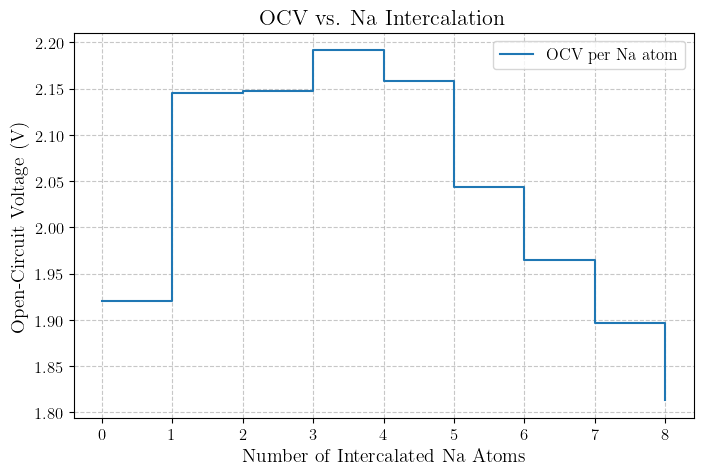

In [631]:
x_values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.figure(figsize=(8, 5))
plt.step(x_values[:-1], Voc_list, where='post', label="OCV per Na atom")
plt.xlabel("Number of Intercalated Na Atoms")
plt.ylabel("Open-Circuit Voltage (V)")
plt.title("OCV vs. Na Intercalation")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Creating intercalcation structures with 1-9 Na ions

In [545]:
m_go_relaxed_omat = io.read("structures/m_go_relaxed_omat.xyz")

In [566]:
import numpy as np
from ase import Atoms

def add_sodium_many(heterostructure, n_Na=9):
    """
    Adds up to `n_Na` sodium ions to the heterostructure, filling the middle row first, 
    then alternating between the top and bottom rows.

    - Middle row (up to 3 Na)
    - Then alternates between top and bottom rows (max 3 each)
    """

    heterostructure = heterostructure.copy()
    
    # Get z-coordinates of graphene (C atoms) and MXene (O atoms)
    graphene_C_atoms = [atom.position[2] for atom in heterostructure if atom.tag == 10]
    mxene_O_atoms = [atom.position[2] for atom in heterostructure if atom.tag == 3]
    
    z_mxene = np.mean(mxene_O_atoms)
    z_graphene = np.mean(graphene_C_atoms)

    # Place Na halfway between MXene and graphene
    na_z = z_mxene + 0.5 * (z_graphene - z_mxene)

    # Get unit cell boundaries
    positions = heterostructure.get_positions()
    xmin, ymin = np.min(positions[:, :2], axis=0)
    xmax, ymax = np.max(positions[:, :2], axis=0)

    # Define y-positions for the three rows
    y_positions = np.linspace(ymin+0.5, ymax-0.5, 3)  # Three distinct rows

    # Define x-positions for each row (evenly spaced)
    x_positions_top = np.linspace(xmin, xmax, 3, endpoint=False)  # 3 in top row
    x_positions_bottom = np.linspace(xmin+5, xmax+5, 3, endpoint=False)  # 3 in bottom row
    
    # Middle row: Offset x-coordinates to be in between the top and bottom row Na positions
    x_spacing = (x_positions_top[1] - x_positions_top[0]) / 2  # Half the x-spacing of top row
    #x_positions_middle = x_positions_top[:-1] + x_spacing  # Shifted to the gaps
    x_positions_middle = np.linspace(xmin + x_spacing, xmax - x_spacing, 3)
    
    # Construct Na positions based on priority order
    placement_order = []
    
    # Fill the middle row first (max 3 Na)
    for x in x_positions_middle:
        placement_order.append((x, y_positions[1]))  # Middle row (y_positions[1])
    
    # Alternate between top and bottom rows
    for i in range(3):
        placement_order.append((x_positions_top[i], y_positions[2]))   # Top row
        placement_order.append((x_positions_bottom[i], y_positions[0])) # Bottom row

    # Trim to match n_Na
    placement_order = placement_order[:n_Na]

    # Create final Na positions
    na_positions = [[x, y, na_z] for x, y in placement_order]

    # Create Na atoms and add them to the heterostructure
    na_atoms = Atoms("Na" * n_Na, positions=na_positions)
    heterostructure += na_atoms  # Append Na to the structure

    return heterostructure


In [ ]:
#m_go_na_1 = add_sodium_many(m_go_relaxed_omat, n_Na=1)
m_go_na_2 = add_sodium_many(m_go_relaxed_omat, n_Na=2)
m_go_na_3 = add_sodium_many(m_go_relaxed_omat, n_Na=3)
m_go_na_4 = add_sodium_many(m_go_relaxed_omat, n_Na=4)
m_go_na_5 = add_sodium_many(m_go_relaxed_omat, n_Na=5)
m_go_na_6 = add_sodium_many(m_go_relaxed_omat, n_Na=6)
m_go_na_7 = add_sodium_many(m_go_relaxed_omat, n_Na=7)
#m_go_na_8 = add_sodium_many(m_go_relaxed_omat, n_Na=8)
m_go_na_9 = add_sodium_many(m_go_relaxed_omat, n_Na=9)

In [576]:
m_go_na_relaxed_2 = m_go_na_2.copy()
m_go_na_relaxed_2.calc = macemp_omat
optimiser = BFGS(m_go_na_relaxed_2)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 19:03:34    -1210.951452        2.680064
BFGS:    1 19:03:36    -1211.238353        2.129090
BFGS:    2 19:03:38    -1211.583313        1.011409
BFGS:    3 19:03:40    -1211.670258        0.804956
BFGS:    4 19:03:42    -1211.823152        0.789435
BFGS:    5 19:03:44    -1211.905739        0.819728
BFGS:    6 19:03:46    -1211.961801        0.767863
BFGS:    7 19:03:48    -1212.044523        0.812296
BFGS:    8 19:03:50    -1212.168119        1.202598
BFGS:    9 19:03:53    -1212.303734        1.115438
BFGS:   10 19:03:55    -1212.457411        0.700866
BFGS:   11 19:03:56    -1212.567756        0.717408
BFGS:   12 19:03:58    -1212.682916        0.682344
BFGS:   13 19:04:00    -1212.775768        0.643272
BFGS:   14 19:04:03    -1212.846036        0.572497
BFGS:   15 19:04:05    -1212.895566        0.498170
BFGS:   16 19:04:07    -1212.953609        0.432031
BFGS:   17 19:04:09    -1212.998564        0.343759
BFGS:   18 19:

True

In [577]:
io.write("structures/m_go_na_relaxed_omat_2.xyz", m_go_na_relaxed_2)

In [578]:
m_go_na_relaxed_3 = m_go_na_3.copy()
m_go_na_relaxed_3.calc = macemp_omat
optimiser = BFGS(m_go_na_relaxed_3)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 19:12:29    -1204.595707        9.486667
BFGS:    1 19:12:31    -1208.234181       13.780728
BFGS:    2 19:12:33    -1211.970653        4.746738
BFGS:    3 19:12:36    -1212.884435        2.599864
BFGS:    4 19:12:38    -1213.578352        1.624717
BFGS:    5 19:12:40    -1213.974589        1.696430
BFGS:    6 19:12:42    -1214.251793        1.477332
BFGS:    7 19:12:44    -1214.496354        1.312170
BFGS:    8 19:12:46    -1214.678225        1.035497
BFGS:    9 19:12:48    -1214.847221        1.568803
BFGS:   10 19:12:50    -1215.019389        1.603371
BFGS:   11 19:12:52    -1215.177696        1.169591
BFGS:   12 19:12:54    -1215.313305        0.802859
BFGS:   13 19:12:57    -1215.384058        0.665049
BFGS:   14 19:12:59    -1215.477306        0.577576
BFGS:   15 19:13:01    -1215.527614        0.554958
BFGS:   16 19:13:03    -1215.582237        0.545747
BFGS:   17 19:13:05    -1215.643269        0.523181
BFGS:   18 19:

True

In [579]:
io.write("structures/m_go_na_relaxed_omat_3.xyz", m_go_na_relaxed_3)

In [580]:
m_go_na_relaxed_4 = m_go_na_4.copy()
m_go_na_relaxed_4.calc = macemp_omat
optimiser = BFGS(m_go_na_relaxed_4)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 19:20:41    -1206.922173        9.632556
BFGS:    1 19:20:44    -1210.791163       13.729648
BFGS:    2 19:20:46    -1214.538663        4.662119
BFGS:    3 19:20:49    -1215.500375        2.581234
BFGS:    4 19:20:52    -1216.249383        1.590584
BFGS:    5 19:20:54    -1216.677629        1.792419
BFGS:    6 19:20:56    -1216.976272        1.494470
BFGS:    7 19:20:58    -1217.244690        1.260758
BFGS:    8 19:21:00    -1217.449548        1.130853
BFGS:    9 19:21:02    -1217.648408        1.669962
BFGS:   10 19:21:04    -1217.856799        1.752701
BFGS:   11 19:21:07    -1218.080467        1.366364
BFGS:   12 19:21:09    -1218.272136        0.982014
BFGS:   13 19:21:11    -1218.383450        0.818317
BFGS:   14 19:21:13    -1218.515809        0.650563
BFGS:   15 19:21:15    -1218.602954        0.711674
BFGS:   16 19:21:17    -1218.693165        0.745138
BFGS:   17 19:21:19    -1218.802782        0.686343
BFGS:   18 19:

True

In [581]:
io.write("structures/m_go_na_relaxed_omat_4.xyz", m_go_na_relaxed_4)

In [582]:
m_go_na_relaxed_5 = m_go_na_5.copy()
m_go_na_relaxed_5.calc = macemp_omat
optimiser = BFGS(m_go_na_relaxed_5)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 19:30:19    -1206.138269        9.745538
BFGS:    1 19:30:21    -1211.673554       13.699078
BFGS:    2 19:30:23    -1216.448313        4.571922
BFGS:    3 19:30:25    -1217.875656        2.475764
BFGS:    4 19:30:27    -1219.119198        1.561338
BFGS:    5 19:30:29    -1219.794125        1.984992
BFGS:    6 19:30:32    -1220.213452        1.666182
BFGS:    7 19:30:35    -1220.589721        1.810754
BFGS:    8 19:30:38    -1220.871926        1.381283
BFGS:    9 19:30:41    -1221.109527        1.377466
BFGS:   10 19:30:43    -1221.328434        1.304312
BFGS:   11 19:30:45    -1221.497185        1.131233
BFGS:   12 19:30:47    -1221.679135        0.779895
BFGS:   13 19:30:50    -1221.823997        0.641735
BFGS:   14 19:30:52    -1221.942238        0.814354
BFGS:   15 19:30:55    -1222.050090        0.710722
BFGS:   16 19:30:57    -1222.156453        0.621166
BFGS:   17 19:30:59    -1222.267869        0.552915
BFGS:   18 19:

True

In [583]:
io.write("structures/m_go_na_relaxed_omat_5.xyz", m_go_na_relaxed_5)

In [584]:
m_go_na_relaxed_6 = m_go_na_6.copy()
m_go_na_relaxed_6.calc = macemp_omat
optimiser = BFGS(m_go_na_relaxed_6)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 19:39:56    -1208.669100        9.823378
BFGS:    1 19:39:58    -1214.401493       13.673677
BFGS:    2 19:40:00    -1219.196141        4.545011
BFGS:    3 19:40:02    -1220.679194        2.462001
BFGS:    4 19:40:04    -1221.997559        1.586783
BFGS:    5 19:40:06    -1222.707408        2.029870
BFGS:    6 19:40:08    -1223.156939        1.679850
BFGS:    7 19:40:10    -1223.571936        1.841214
BFGS:    8 19:40:12    -1223.901792        1.518344
BFGS:    9 19:40:14    -1224.197340        1.586176
BFGS:   10 19:40:16    -1224.506516        1.540694
BFGS:   11 19:40:18    -1224.739385        1.331516
BFGS:   12 19:40:20    -1224.975753        0.862871
BFGS:   13 19:40:22    -1225.164249        0.644213
BFGS:   14 19:40:24    -1225.307880        0.841793
BFGS:   15 19:40:26    -1225.422545        0.758489
BFGS:   16 19:40:28    -1225.539646        0.607274
BFGS:   17 19:40:30    -1225.669177        0.567898
BFGS:   18 19:

True

In [585]:
io.write("structures/m_go_na_relaxed_omat_6.xyz", m_go_na_relaxed_6)

In [586]:
m_go_na_relaxed_7 = m_go_na_7.copy()
m_go_na_relaxed_7.calc = macemp_omat
optimiser = BFGS(m_go_na_relaxed_7)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 19:48:26    -1207.847294        9.871407
BFGS:    1 19:48:28    -1215.271835       13.644905
BFGS:    2 19:48:30    -1220.665325        4.527019
BFGS:    3 19:48:32    -1222.708229        2.307434
BFGS:    4 19:48:35    -1224.458671        1.651911
BFGS:    5 19:48:37    -1225.368410        2.056371
BFGS:    6 19:48:39    -1225.930978        1.633063
BFGS:    7 19:48:42    -1226.413172        1.728848
BFGS:    8 19:48:44    -1226.878334        1.724291
BFGS:    9 19:48:46    -1227.227458        1.746343
BFGS:   10 19:48:49    -1227.572969        1.386912
BFGS:   11 19:48:51    -1227.806574        1.150408
BFGS:   12 19:48:53    -1227.988682        0.742505
BFGS:   13 19:48:55    -1228.134260        0.586782
BFGS:   14 19:48:57    -1228.232236        0.731245
BFGS:   15 19:49:00    -1228.309727        0.540560
BFGS:   16 19:49:02    -1228.384543        0.417254
BFGS:   17 19:49:04    -1228.469545        0.414067
BFGS:   18 19:

True

In [587]:
io.write("structures/m_go_na_relaxed_omat_7.xyz", m_go_na_relaxed_7)

In [588]:
m_go_na_relaxed_9 = m_go_na_9.copy()
m_go_na_relaxed_9.calc = macemp_omat
optimiser = BFGS(m_go_na_relaxed_9)
optimiser.run(fmax=0.001, steps=5000)

      Step     Time          Energy          fmax
BFGS:    0 19:58:42    -1181.308054       37.551427
BFGS:    1 19:58:44    -1198.553840       17.334184
BFGS:    2 19:58:47    -1214.661910        8.362101
BFGS:    3 19:58:49    -1221.287969        5.010515
BFGS:    4 19:58:51    -1225.075884        3.356064
BFGS:    5 19:58:53    -1227.587090        2.362102
BFGS:    6 19:58:55    -1229.228139        1.742382
BFGS:    7 19:58:57    -1230.324745        1.508959
BFGS:    8 19:59:00    -1231.037990        2.140286
BFGS:    9 19:59:02    -1231.643793        2.122397
BFGS:   10 19:59:05    -1232.251368        1.450348
BFGS:   11 19:59:07    -1232.583868        1.182813
BFGS:   12 19:59:09    -1232.934795        0.757553
BFGS:   13 19:59:11    -1233.093129        0.748516
BFGS:   14 19:59:13    -1233.260297        0.698045
BFGS:   15 19:59:16    -1233.423081        0.690672
BFGS:   16 19:59:19    -1233.557623        0.621427
BFGS:   17 19:59:21    -1233.667194        0.489976
BFGS:   18 19:

True

In [589]:
io.write("structures/m_go_na_relaxed_omat_9.xyz", m_go_na_relaxed_9)